# Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.visualization import plot_circuit_layout, plot_gate_map
import mapomatic as mm

from qiskit.utils import QuantumInstance
from qiskit import IBMQ, transpile

from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import SPSA

import pathlib
import sys

import time

# Load the problem

In [2]:
# Define routines to create QUBO

def Generate_QuboMatrixMarkowitz(covariances, mu, risk=None,cost=None,budget=None,penalty=None):
    #Input: covariances = Kovarianzmatrix
    # mu = Erwartungswertvektor
    # risk = Risikofaktor
    # cost = Vektor mit Kosten für einzelne Assets/Assetklassen
    # budget = verfügbares Budget zum Kaufen der Assets
    # penalty = Strafterm für die Nebenbedingung
    #Output: Qubomatrix für Markowitzproblem mit Budgetnebenbedingung, offset Konstante
    num_assets=len(mu)
    test=None
    if type(risk)== type(test):
        risk=0.5
    if type(cost)== type(test):
        cost=np.ones(num_assets)
    if type(budget)== type(test):
        budget=num_assets // 2 
    if type(penalty)== type(test):
        penalty=num_assets
    QuboMatrix=risk*(2*np.triu(covariances)-np.diag(np.diag(covariances)))-np.diag(mu)-2*budget*penalty*np.diag(cost)+penalty*(2*np.triu(np.outer(cost,cost))-np.diag(cost**2))
    Constant=penalty*budget**2
    return QuboMatrix, Constant

def Generate_QPMarkowitz(matrix, constant):
    #Input: matrix = QuboMatrix
    # constant = offset Konstante
    # Output: Quadratic Program für Qiskit. Achtung: Die minimize funktion macht bei dem quadratischen Term immer ein 1/2 davor!
    num_assets=len(matrix)
    mod = QuadraticProgram("Markowitz")
    mod.binary_var_dict(num_assets, 'x', '{}')
    mod.minimize(constant=cons, quadratic=matrix)
#     print(mod.export_as_lp_string())
    return mod

In [3]:
### import data ###
o_assets = pd.read_excel(r'Anonymisiertes_PF_Paper.xlsx',
                        sheet_name='Assetklassen', 
                        skiprows = 2)
o_correlations = pd.read_excel(r'Anonymisiertes_PF_Paper.xlsx', 
                             sheet_name='Korrelationsparameter', 
                             skiprows = 2,
                             index_col = 0)

### obtain original variables ###
o_num_assets = len(o_assets)
o_mu = np.array(o_assets.mu)
o_sigma = np.array(o_assets.sigma)
o_covariances = np.matmul(np.matmul(np.diag(o_sigma), o_correlations), np.diag(o_sigma))

### set replication factor ###
factor_synth = 1                       # factor of synthetization
factor_classes = 6                     # number of assets (1 <= factor_classes <= len(assets))

### obtain temp covariances
o_covariances_tmp = o_covariances.loc[:factor_classes-1, :factor_classes-1]

### obtain synthetized variables ###factor_classes
assets = o_assets.drop(o_assets.index[[range(factor_classes, o_num_assets)]])
num_assets = len(assets)
mu = np.repeat(o_mu[0:num_assets], factor_synth)
sigma = np.repeat(o_sigma[0:num_assets], factor_synth)

repelem  = lambda a, x, y: a.repeat(x, 0).repeat(y, 1)
covariances = repelem(o_covariances_tmp.values, factor_synth, factor_synth)


### set further variables ###
q = 1                                    # set risk factor
budget = num_assets // 2                 # set budget
penalty = num_assets                     # set parameter to scale the budget penalty term

M,cons=Generate_QuboMatrixMarkowitz(covariances, mu, q, None, budget, penalty)
qubo=Generate_QPMarkowitz(M,cons)

C:\Users\koppe\anaconda3\envs\qiskit__new\lib\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


# Classical solution with CplexOptimizer

In [4]:
result = CplexOptimizer().solve(qubo)

In [5]:
res_exact = ''
for ele in result.x:
    res_exact += str(int(ele))
print(res_exact)

101001


# QAOA with MinimumEigenOptimizer

### Optimize circuit realization

In [6]:
# Load IBMQ acount and choose backend
with open('C:\\Users\koppe\Desktop\ibmq_germany_ma.txt', 'r') as file:
    token = file.read().rstrip()
APITOKEN = token
APIURL = 'https://auth.de.quantum-computing.ibm.com/api'
IBMQ.enable_account(APITOKEN, APIURL)
provider = IBMQ.get_provider(hub='fraunhofer-de', group='fhg-all', project='ticket')
backend = provider.get_backend('ibmq_ehningen')
backend_name = backend.name()

# # Use devices outside of Germany (consider max number of shots!)
# with open('C:\\Users\koppe\Desktop\ibmq_states.txt', 'r') as file:
#     token = file.read().rstrip()
# IBMQ.save_account(token, hub='ibm-q-fraunhofer', group='fhg-all', project='ticket', overwrite = True)
# provider = IBMQ.load_account()
# # provider = IBMQ.get_provider(hub='ibm-q-fraunhofer', group='fhg-all', project='ticket')
# backend = provider.get_backend('ibmq_brooklyn')

In [7]:
# Get the Hamiltonian
ham_prob, offset = qubo.to_ising()
# print(ham_prob)

In [8]:
# Get the initial circuit for the QAOA
# Generally make sure that the number of shots does not exceed the allowed number of shots 
# according to the respective backend (Ehningen 100000)
seed_ini = np.random.randint(1000)
qi_ini = QuantumInstance(
    backend = backend,
    shots = 1024,
    seed_transpiler = seed_ini
    )

qaoa_ini = QAOA(
    quantum_instance = qi_ini,
    reps=1,
    optimizer=SPSA(100) 
    )

In [9]:
# Extract the initial variational form and get its characteristics
qaoa_qc_ini = qaoa_ini.construct_circuit([1,1],ham_prob)[0]
qaoa_qc_ini_trans = transpile(qaoa_qc_ini, backend=backend)
#display(qaoa_qc_ini_trans.draw('mpl'))
print('initial depth: ', qaoa_qc_ini_trans.depth())
print('initial cx count: ', qaoa_qc_ini_trans.count_ops()['cx'])

initial depth:  84
initial cx count:  84


In [10]:
# Define the callback function for transpiler
def callback_func(**kwargs):
    property_set = kwargs['property_set']
    property_list.append(property_set)

In [11]:
# Start repeated transpilation for finding the optimizing the circuit realization
rep_trans = 50

seeds = list(range(rep_trans))
min_cx_count = 1e99
qaoa_qc_inter = None

cx_count_list = []

# Start time
start_time = time.time()

for kk in range(rep_trans):
    property_list = []
    qaoa_qc_trans = transpile(qaoa_qc_ini, backend=backend,
                              seed_transpiler=seeds[kk],
                              optimization_level= 3,
                              callback = callback_func)
     
    temp_cx_count = qaoa_qc_trans.count_ops()['cx']
    cx_count_list.append(temp_cx_count)
    if temp_cx_count < min_cx_count:
        min_cx_count = temp_cx_count
        qaoa_qc_inter = qaoa_qc_trans
        layout = property_list
        
# End time
end_time = time.time()

print(round(end_time-start_time,4),'s needed for repeated transpilation')

14.7172 s needed for repeated transpilation


In [12]:
# Print optimum realization from repeated transpiling
# display(qaoa_qc_inter.draw('mpl', fold=False))
print('circuit depth: ', qaoa_qc_inter.depth())
print('cx count: ', min_cx_count)

circuit depth:  77
cx count:  45


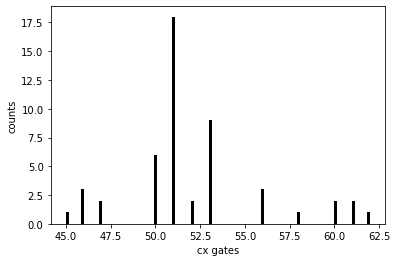

In [13]:
# Plot the distribution of found cx-gate counts as histogram
plt.hist(cx_count_list, bins=100, color='black')
plt.xlabel('cx gates')
plt.ylabel('counts');
plt.savefig('histogram')

In [14]:
# Number of qubits
numb_qu = factor_classes*factor_synth

# Extracting the qubit mapping used in the best circuit from above
best_layout_dict = layout[len(layout)-1].get('layout').get_virtual_bits()
best_layout_help = []

# Get the sublist with virtual and respective physical qubit as sublist entries
for counter,qubit in enumerate(best_layout_dict.items()):
    if counter < numb_qu:
          best_layout_help.append([qubit[0].index,qubit[1]])

# Ordering according to the virtual qubits
best_layout_tr = []
for ele in sorted(best_layout_help, key=lambda x: x[0]):
    best_layout_tr.append(ele[1])
best_layout_tr

C:\Users\koppe\AppData\Local\Temp\ipykernel_18048\3157793263.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  best_layout_help.append([qubit[0].index,qubit[1]])


[24, 25, 23, 26, 22, 19]

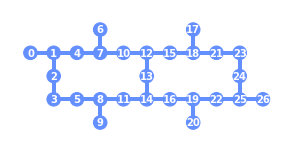

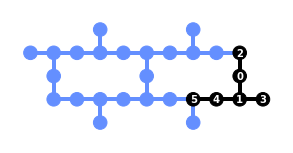

In [15]:
# Show mapping employed at the moment
display(plot_gate_map(backend))
display(plot_circuit_layout(qaoa_qc_inter,backend,view='virtual'))

In [17]:
# Reduce the circuit using mapomatic
small_circ = mm.deflate_circuit(qaoa_qc_inter)
# display(small_circ.draw('mpl'))

# Find the best mapping regarding error rates
layouts = mm.matching_layouts(small_circ, backend)
scores = mm.evaluate_layouts(small_circ, layouts, backend)
best_layout_mm = scores[0][0]
best_layout_mm

[7, 10, 14, 13, 12, 15]

In [18]:
# Translating best layout from mm to original qubit mapping setup
help_ind = np.argsort(best_layout_tr)
best_layout =  np.arange(0,numb_qu,1)
for lll in range(len(best_layout_tr)):
    best_layout[help_ind[lll]] = best_layout_mm[lll]
best_layout

array([13, 12, 14, 15, 10,  7])

In [19]:
# Repeat transpilation again with new best initial layout
min_cx_count = 1e99
qc_best = None
best_seed = None

# Start time
start_time = time.time()

for kk in range(rep_trans):
    property_list = []
    qaoa_qc_trans_cu = transpile(qaoa_qc_ini, backend=backend,
                              initial_layout=best_layout,
                              seed_transpiler=seeds[kk],
                              optimization_level= 3)
     
    temp_cx_count = qaoa_qc_trans_cu.count_ops()['cx']
    if temp_cx_count < min_cx_count:
        min_cx_count = temp_cx_count
        best_seed = seeds[kk]
        qc_best = qaoa_qc_trans_cu
        
# End time
end_time = time.time()

print(round(end_time-start_time,4),'s needed for repeated transpilation')

8.1052 s needed for repeated transpilation


In [20]:
# Checking whether cx count is identical with new layout
# Sometimes it is slightly better or worse, I do not understand why. 
# The reconstruction of the qubit mapping works fine to me

# Print optimum realization
# display(qc_best.draw('mpl'))
print('depth: ', qc_best.depth())
print('cx count: ', min_cx_count)

depth:  75
cx count:  43


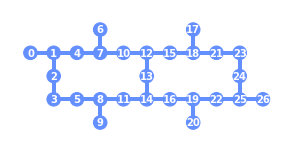

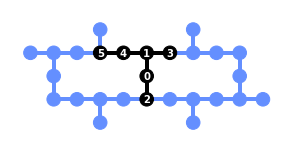

In [21]:
# Show new mapping according to mm
display(plot_gate_map(backend))
display(plot_circuit_layout(qc_best,backend,view='virtual'))

In [ ]:
# Initializing QAOA with the best circuit
qi = QuantumInstance(
    backend = backend,
    shots = 100000,
    seed_transpiler = best_seed,
    initial_layout = best_layout,
    optimization_level= 3
    )

qaoa = QAOA(
    quantum_instance = qi,
    reps=1,
    optimizer=SPSA(100) 
    )

In [ ]:
result_qaoa = MinimumEigenOptimizer(qaoa).solve(qubo)

In [ ]:
qaoa_res = ''
for ll in result_qaoa.x:
    qaoa_res += str(int(ll))

In [ ]:
print('classical result:\t', res_exact)
print('QAOA result:\t\t', qaoa_res)

In [ ]:
# Evaluated samples
av_energy = 0
prob_ground = 0
for ele in sorted(result_qaoa.samples, key=lambda sample: sample.probability)[::-1]:
    helper = ''
    for kk in ele.x:
        helper += str(int(kk))    

    av_energy += ele.probability*ele.fval

    if helper == res_exact:
        prob_ground = ele.probability
        
rel_opt = result_qaoa.fval
rel_opt_mes = av_energy
rel_search_space = len(result_qaoa.samples)/2**numb_qu       
        
print(f'{qaoa_res}\t {round(rel_opt,2)}\t\t {round(rel_opt_mes,2)}\t\t {round(prob_ground,6)}\t\t {round(rel_search_space,3)}')

In [ ]:
# print(result_qaoa.min_eigen_solver_result)